# Chapter 03 - Classification 

In the first chapter the author mentioned that the most common form of supervised learning tasks are regression (where we are prediciting continuous variables) and classification (prediciting classes). In the previous chapter we explored a regression task, where we looked at prediciting the house prices using several types of algorithms, such as linear regression, decision trees and random forests. In this chapter, we are going to look at classification tasks. 

### MNIST Dataset 

For this chapter we will be using the MNIST dataset, this is a dataset of 70 thousand labelled images of handwritten numbers. The set has been studied so much that it is often called the "hello world" of machine learning (thinking back to when I did my first hello world when I started to learn coding). Whenever people come up with new classification algorithms, the first thing they do is test it on the MNIST dataset to see how it fairs. Anyone who does machine learning or is learning machine learning has tackled or is going to tackle this dataset at some point!!!!

Scikit-learn provides many helper funtions to download popular datasets such as the MNIST dataset, the following code fetches the dataset for us. 

In [1]:
from sklearn.datasets import fetch_openml 

mnist = fetch_openml('mnist_784', version=1, as_frame = False) # we need to set the as_frame = false as skikit learn has updated

mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Datasets that are loaded in my scikit learn generally have a similar dictionary structure that include the following. 

- A DESCR key describing the dataset
- A data key containing an array with one row per instance and one colum per feature 
- A target key that contains all of the labels for each of the instances

Let's look at these arrays below

In [2]:
X, y = mnist['data'], mnist['target']

In [3]:
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

There are 70 thousand iages and each image is made up of 784 features. This is because each image is 28 x 28 pixels and each feature is simply representing the pixels intensity from 0 (which is white) to 255 (which is black). Lets take a look at one of the digits on our dataset. All we need to do is grab an instances feature vector (we know what these are now) and reshape it into the 28 x 28 array, and thi display it using Matplotlibs imshow() function. 

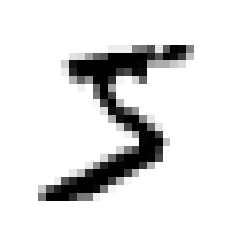

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

first_digit = X[0]

first_digit_image = first_digit.reshape(28, 28)

plt.imshow(first_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [6]:
y[0]

'5'

Perfect it's a five, note that the label is a string. Most ML algorithms expect numbers to be fed into them lets cast y to an integer. 

In [7]:
# converting all of the strings into integers
y = y.astype(np.uint8)

Remember that before we go onto analyse the dataset we need to create a test set. The MNIST dataset is actually already split into a training and test split (the first 60,000 are training and the last 10,000 is testing) so lets create our test train split. 

In [8]:
X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]

It should be noted that the dataset is already shuffled which is good because it means that the cross validation folds should contain similar amount of each digit, as well as this machine learning algorithms don't tend to like being fed instances that are too similar one after eachother, shuffling the dataset ensures this wont happen. 

### Training a Binary Classifer

Let us go through a simpler problem for now, and simply try and identify one digit - for example the number 5 we have just looked at !!!! This "5-detector" lol will be an example of what is called a **binary classifer**, capable of distinguishing between just two classes (5 and not 5). Lets create the target vectors for the classification task.


In [10]:
y_train_5 = (y_train == 5) # setting the 5 labels to be the 5 training set
y_test_5 = (y_test == 5)

Now lets pick a classifier and train it. A good place to start is with a **stochastic gradient descent (SGD) classifier** using Scikitlearns SDGClassifer class. This has the advantage of being able to handle very large datasets efficiently. This is in part because the SGD classifier deals with training instances independently, one at a time (this also makes the SDG classifier really good for online learning) as we will see later. Lets create an SGD classifier and train it on the whole training dataset. 

In [16]:
from sklearn.linear_model import SGDClassifier 

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5) # Either it is a 5 or it isn't a 5

SGDClassifier(random_state=42)

NOTE: The stochastic gradient descent relies on randomness during training (hence the name "stochastic"). If we want repoducible results, we need to set the random seed. 

Now lets use it to classify an image

In [15]:
sgd_clf.predict([first_digit]) # note that this is in [] 

array([ True])

YAY, the classifier guesses that the image is a 5 (True). This looks like its guessed right in this case. Now let's evaluate this models performance overall.

### Performance Measure

Evaluating a classifier is often significantly trickier than evaluating a regressor, so we will be spending a large part of this chapter covering the this topic. There are many perfromance measures at our disposal, so grab a coffee and get ready to learn some new concepts and some new acronyms!!!!!!

### Measuring Accuracy Using Cross-Validaton 

A great way to evaluate a model is to use cross validation, just like we did in chapter 2.

However sometimes we will need more control over the cross validation process than what scikit-learn provides to us. In these cases, you can implement cross validation by hand. The following code does roughly the same thing as scikitlearns cross_val_score() function and it prints the same result. 

Lets take this oppourtunity to understand the inner mechanics of how the cross val score function work.

In [25]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5): # splitting the data training set and label
    clone_clf = clone(sgd_clf) # create a clone of the sgd classifier
    X_train_folds = X_train[train_index] # assign the value to the x train set 
    y_train_folds = y_train_5[train_index] # assign the value to the y train set
    X_test_fold = X_train[test_index] # assign the value to the x test set 
    y_test_fold = y_train_5[test_index] #assign the value to the y test set

clone_clf.fit(X_train_folds, y_train_folds)
y_prediction = clone_clf.predict(X_test_fold)
number_correct = sum(y_prediction == y_test_fold)
print(number_correct / len(y_prediction))

0.96785


The StratifiedKFold class performs stratified sampling to produce folds that contan a representative ratio of each class. At each iteration the code creates a clone of the classifier, trains that clone classifier on the training folds and makes predictions on that test. It then counts the number of correct predictiions and outputs the ratio of correct predictions

Now lets use the cross_val_score() function using our SDG classifier using K fold cross validation with three folds. Remeber that K fold cross validation means splitting the the training set into K folds (in this case 3), then making predictions and evaluating them on each fold using a model trained on remaining folds. 

In [27]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

WOW! above 90% accuracy (the ratio of correct predictions) on all cross validation folds! This looks amazing, but sadly this isn't the case, before we get too excited lets look at a really dumb classifier that simply just classifies everything in this dataset as "not a 5".

In [29]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

Can we guess the models accuracy??? Lets have a look!

In [31]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

Lol thats funny, we have around 90% accuracy by simply just saying everything is a 5. This is becuase only about 10% of the MNIST dataset is a 5. So if we always guess that it is not a 5, we will still get a really high score. 

This demonstrates why accuracy is generally not a great performance metric for classifiers. Especially when we are dealing with skewed datasets (when one of the classes is much more fequent than the other).

### Confusion Matrix 

A much better way to evaluate the performance of a classifier is the use a confusion matrix. The general idea for the confusion matrix is to count the number of times instances of a class A are classified as class B. For example, to know how many times the classifier confused images of 5s as 3s we would look on the 5th row an the 3rd column of the confusion matrix. 

To compute the confusion matrix, we first need a set of predictions, so that they can be compared with the actual targets. For this we use the cross_val_predict() function. 

In [32]:
from sklearn.model_selection import cross_val_predict

y_train_predictions = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Just like cross_val_score(), cross_val_predict() preforms Kfold cross validations but instead of returning evaluation scores, it returns the predictions made on each test fold. This means that we get a clean predicition for each instance in the training set (the term 'clean' means that the predicition was made by the model on an instance that it has not seen before in training). 

Now that we are ready to get to the confusion matrix we can get this by using the confusion_matrix() function. Just pass the target class and the predicted class into the function.

In [34]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_predictions)

array([[53892,   687],
       [ 1891,  3530]])

Each row in the confusion matrix represents and **actual** class, while each column represents a **predicted** class. The first row of this matrix considers the non-5 images (the negative class). 53892 of them were correctly predicted as negative, while the remaining 687 were wrongly classified as 5s (flase positive) when they actually were not 5s. On the second row is the positive class (images of 5), 1891 were falsely identified as not 5s (false negative) when in fact there were and 3530 images were correctly identified as 5s (true positive) in the cross validation. A perfect classifier would only have true positives and true negatives while having nonzero values on the main diagonal (top left to bottom right). 

In [36]:
y_train_perfect_predicitions = y_train_5 # we are pretending that we have reached perfect predictions
confusion_matrix(y_train_5, y_train_perfect_predicitions)

array([[54579,     0],
       [    0,  5421]])

The confusion matrix gives you a lot of information, but sometimes we may prefer a more concise metric. An interesting metric is the **precision** of the classifier, this is the accuracy of positive predicitions, and is defined as:

Equation 3.1 Precision

precision $= \frac{TP}{TP + FP}$

TP is the true positive rate and FP is the false positive rate. A trivial way to have 100% precision is to make only one prediction and make sure that predicition is correct (precision = 1/1 = 100%). But this would not be very useful would it!!! So typically we use precision in conjunction with **recall**, also called **sensitivty** or the **True positive rate**, this is the ratio of positive instances that are correctly detected by the classifier. 

Equation 3.2 Recall / True Positive Rate

Recall $= \frac{TP}{TP + FN}$

FN is the number of false negatives predictd by the classifier (the 5s that were missclassifed as 3s) 

### Precision and Recall 

Scikit-learn provides several functions that allow us computre classifier metrics, including precision and recall

In [37]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_predictions)

0.8370879772350012

In [39]:
recall_score(y_train_5, y_train_predictions)

0.6511713705958311

Now that we have broken our SGD classifier down we can now see it is not as great as first seen. We now can see that when our classifier says its a 5, its only a 5 83% of the time, not the > 90% that we got using accuracy. Moreover, our classifier only picks up 65% of the 5s that are actually in the dataset! Thats not great. 

It is often convenient when we are comparing classifiers to merge the precision and recall into one metric, this metric is termed the $F_1$ score. The $F_1$ score is the **harmonic mean** of precision and recall (Equation 3.3). Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result the classifier will only get a high $F_1$ score if both recall and precision are high. 

Equation 3.3 $F_1$ score 

$F_1$  = $\frac{2}{\frac{1}{precision}+\frac{1}{recall}}$ = $2 \times \frac{precision \times recall}{precision + recall}$ = $\frac{TP}{TP} + \frac{FN + FP}{2}$

To compute the $F_1$ score, we can simply call the $F_1$ function. 

In [41]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_predictions)

0.7325171197343846

The $F_1$ score favours classifiers that have similar precision and recall. This is not always what we want however. Some contexts demand that we care more about precision and others demand more recall. If we were training a classifier to filter content for a childerens site. We would favour precision to be high as we would prefere a classifier that rejects many good videos (low recall) but we know that all videos on the website are okay for the child to watch. We might even want to have a human pipeline at the end that double checks the classifier and its decision. Whereas if we were building a security camera software, we would prefer to have a higher recall. This means that the security guards may be altered to some false alarms (false postives and lower precision) but we can be sure that all of the shoplifters are caught. 

Unfortunately, we cannot have it both ways! Increasing precision of the model reduces recall and increasing recall reduces precision (there is no way we can increase both at the same time). This is called the **precision recall tradeoff**.